#Libraries imports

In [ ]:
import numpy as np
import torch
from torchvision import transforms , datasets
from torch . utils . data . sampler import SubsetRandomSampler
import torch.nn.functional as F

import torch.nn as nn 

# Data Normalization/Augmentation/Imports/Splitting

Here we are gonna normalize and resize the image using parameters details in the ResNet paper 

A 224×224 crop is randomly sampled from images like detailed in the paper. 

In [ ]:

train_transform = transforms.Compose([ #resises the image so it can be perfect for our model.
           transforms.Resize((224,224)),
            transforms.ToTensor(), # convert the image to tensor so that it can work with torch
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010]) #Normalize all the images
            ])
val_transform = transforms . Compose ([ 
           transforms.Resize((224,224)),
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
            ])
test_transform = transforms . Compose (
[ transforms.Resize((224,224)),
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
            ])
batch_size = 256
trainset = datasets . CIFAR10 ( root ='./ data' , train =True ,
download =True ,transform = train_transform )
valset = datasets . CIFAR10 ( root ='./ data', train =True ,
download =True ,
transform = val_transform )
testset = datasets . CIFAR10 ( root ='./ data ', train =False ,
download =True ,
transform = test_transform )
classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Indices for train /val splits : train_idx , valid_idx
np . random.seed ( 0 )
val_ratio = 0.1
train_size = len( trainset )
indices = list ( range ( train_size ) )
split_idx = int( np . floor ( val_ratio * train_size ) )
np . random . shuffle ( indices )
train_idx , val_idx = indices [ split_idx :], indices [: split_idx ]
train_sampler = SubsetRandomSampler ( train_idx )
val_sampler = SubsetRandomSampler ( val_idx )
train_loader = torch.utils.data.DataLoader ( trainset , batch_size = batch_size ,
sampler = train_sampler ,
num_workers =2 )
val_loader = torch . utils . data . DataLoader ( valset , batch_size = batch_size ,
sampler = val_sampler ,
num_workers =2 )
test_loader = torch . utils . data . DataLoader ( testset , batch_size = batch_size ,
shuffle =False , num_workers =2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./ data/cifar-10-python.tar.gz to ./ data
Files already downloaded and verified


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./ data /cifar-10-python.tar.gz to ./ data 


# Model Implementation

## ResidualBlockNetwork

Here we Instanciate the ResidualBlock of for our ResNet network. 

Residual Network : We
insert shortcut connections which turn the
network into its counterpart residual version. The identity
shortcuts can be directly used when the input and
output are of the same dimensions . When the dimensions increase , we consider two options: (A) The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter; (B) The projection shortcut is used to
match dimensions (done by 1×1 convolutions). For both
options, when the shortcuts go across feature maps of two
sizes, they are performed with a stride of 2.


In [ ]:
class ResidualBlock(nn.Module):
	
    def __init__(self, in_p, out_p, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_p, out_p, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_p)
        
        self.conv2 = nn.Conv2d(out_p, out_p, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_p)
      
        self.shortcut = nn.Sequential()
       
        if stride != 1: 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_p, out_p, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_p)
            )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x += self.shortcut(x) 
        x = F.relu(x)
        return x


## ResNet Model Implementation

We instanciate our ResNet model that can be applicable for the ResNet 20 and 34

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_p = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_p != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.in_p, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.in_p, planes, stride))
        self.in_p = planes
        for i in range(1, blocks):
            layers.append(block(self.in_p, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Training

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We
use a weight decay of 0.0001 and a momentum of 0.9. We
do not use dropout; For best results, we adopt the fullyconvolutional form as in and average the scores
at multiple scales (images are resized such that the shorter
side is in {224, 256, 384, 480, 640}). We initialize the weights
 and train all residual nets from scratch. We
use SGD with a mini-batch size of 256.
We adopt batch
normalization (BN) right after each convolution and
before activation function.


In [ ]:
nb_of_epochs = 10
batch_size = 256
learning_rate = 0.01

model = ResNet(ResidualBlock,  [2, 2, 2, 2]).to(device)

# Loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.0001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

We train and evaluate our model for each epochs using the validation dataset. 

In [ ]:
total_step = len(train_loader)

for epoch in range(nb_of_epochs):
    model.train()
    for i, (train, target) in enumerate(train_loader):  
        # We use the GPU to run the code. We set datasets to use GPU for all type of computational tasks
        train = train.to(device)
        target_values = target.to(device)
        
        # We train our model here using the forward function
        outputs = model(train)
        # We calculate the loss
        loss = loss_function(outputs, target_values)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        torch.cuda.empty_cache()

    print ("Epoch [" + str(epoch+1) +"/" + str(nb_of_epochs) +" ] loss : " + str(loss.item()))
            
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred = torch.empty(0).to(device)
        val_loss = 0
        target_values = torch.empty(0).to(device)
        for val, target in val_loader:
            val = val.to(device)
            target = target.to(device)
            outputs = model(val)
            _, prediction = torch.max(outputs.data, 1)

            loss = loss_function(outputs,target)
            val_loss+=loss.detach()

            pred = torch.cat((pred,prediction),0)
            target_values = torch.cat((target_values,target),0)

        val_loss = val_loss/len(target_values)
        accuracy = torch.sum(pred == target_values)
        accuracy2 = (float(accuracy / len(target_values))*100)
        print("Validation Loss : ", str(round(float(val_loss),5))," Validation Accuracy : ", accuracy2)

Epoch [1/10 ] loss : 0.6212520003318787
Validation Loss :  0.00296  Validation Accuracy :  74.8799979686737
Epoch [2/10 ] loss : 0.48123499751091003
Validation Loss :  0.00369  Validation Accuracy :  71.37999534606934
Epoch [3/10 ] loss : 0.39158013463020325
Validation Loss :  0.0034  Validation Accuracy :  74.61999654769897
Epoch [4/10 ] loss : 0.25923049449920654
Validation Loss :  0.00345  Validation Accuracy :  75.25999546051025
Epoch [5/10 ] loss : 0.1331242471933365
Validation Loss :  0.00315  Validation Accuracy :  78.07999849319458
Epoch [6/10 ] loss : 0.1468190997838974
Validation Loss :  0.00335  Validation Accuracy :  76.69999599456787
Epoch [7/10 ] loss : 0.036798883229494095
Validation Loss :  0.00285  Validation Accuracy :  80.47999739646912
Epoch [8/10 ] loss : 0.011829700320959091
Validation Loss :  0.00233  Validation Accuracy :  83.67999792098999
Epoch [9/10 ] loss : 0.0036670302506536245
Validation Loss :  0.00215  Validation Accuracy :  84.8800003528595
Epoch [10/10

We can see that the Validation Accuracy is up to 86%. We can assume that maybe the model can have a better accuracy with more epochs but it takes times to run a model more that 40 epochs. 

# Test experiments

Test results

In [ ]:
# Validation
with torch.no_grad():
        pred = torch.empty(0).to(device)
        test_loss = 0
        target_values = torch.empty(0).to(device)
        for test, target in test_loader:
            test = test.to(device)
            target = target.to(device)
            outputs = model(test)
            _, predicted = torch.max(outputs.data, 1)

            loss = loss_function(outputs,target)
            test_loss+=loss.detach()
            pred = torch.cat((pred,predicted),0).to(device)
            target_values = torch.cat((target_values,target),0).to(device)

        test_loss = test_loss/len(target_values)
        accuracy = torch.sum(pred == target_values)
        accuracy2 = (float(accuracy / len(target_values))*100)
        print("Test Loss : ", str(round(float(test_loss),5))," Test Accuracy : ", accuracy2)

Test Loss :  0.00218  Test Accuracy :  84.82999801635742


#Final Results : accuracy of 85% for the test set with the ResNet-20

Finally we have an accuracy of 85% for the test set with the ResNet-20 

Let's detailed the whole process to get an test accuracy higher than 80%. First in the previous assignment we achieved an 58% accuracy without optimization either hyperparameter tunning. 

First of all we resize the image 224x224 according to the ResNet paper. We also normalize our 3 datasets using mean and standard deviation. After we build the Residual Block that will be using in our ResNet-20 model. We use this residual bloc because  if we keep increasing the number of layers, we will see that the accuracy will saturate at one point and eventually degrade. And, this is usually not caused due to overfitting. We skip the training of few layers using skip connections or residual connections. The layers in a traditional network are learning the true output (H(x)), whereas the layers in a residual network are learning the residual (R(x)). Where : R(x) = Output — Input = H(x) — x. The residual block is composed of two convolution layer followed by batch normalization.  We
insert shortcut connections which turn the
network into its counterpart residual version. The identity
shortcuts can be directly used when the input and
output are of the same dimensions. When the dimensions increase,  we consider two options: 
- The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter
- The projection shortcut is used to
match dimensions (done by 1×1 convolutions). They are performed with a stride of 2.

Afterwards we move to our ResNet-20 model. We initialize the weights
and residual nets from scratch. We
use SGD with a mini-batch size of 256. The learning rate
starts from 0.1. We
use a weight decay of 0.0001 and a momentum of 0.9. We
do not use dropout. The Resnet is composed of 20 layers.We first instanciate an sequence with convolution layer,batch norm, relu as activation and a max pool layer.Followed by layers of 2 x 64,128,256,512 of convolution layers each conv layer followed by batch norm and at the end the avg pool detailed in the ResNet Paper and a Fully connected layer that will shows probability for each class. 

We generate layers using function that build the resenet classifier using residual block to skip some connections. 

Then we train the model with 10 epochs and for each epoch we evaluate our model with loss_validation and validation accuracy. We found a final accuracy of 86% for the validation data set. 

We try the model on the test set and we found a final test accuracy of 85%. Thanks to the training part and the ResNet model we have perform an experiment that leads to an accuracy that is higher than 80%. 

I tried to tune the hyperparemeters but it is time and GPU consuming. 

In [ ]:
epochs = [i for i in range(1,11)]
train_loss = [0.03679,0.01182,0.00366,0.001760]
train_acc = [75,76.3,76,80,82,82,84,84.6,85,88]



val_loss = [ 0.00285,0.00233, 0.00215,0.00201]

val_acc = [74.8,71.3,74.619,75.259,78.0799,76.699,80.479,83.679,84.880, 85.8799]

In [ ]:
import matplotlib.pyplot as plt

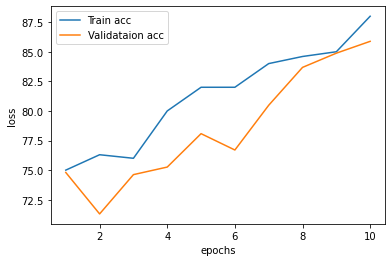

In [ ]:
plt.plot(epochs,train_acc)
plt.plot(epochs,val_acc)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Train acc', 'Validataion acc'])
plt.show()